In [288]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from model import CreditModel

import matplotlib.pyplot as plt
data = np.loadtxt('data/credit-data.csv', dtype=np.int, delimiter=',', skiprows=1)
X, y = data[:, 1:-1], data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [250]:
def sigmoid(Z):
    """
    Arguements:
        Z -- input for activation
    
    returns:
        A -- result of activation function
        cache -- store Z for back prop
    """
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A,cache

In [251]:
def sigmoid_back(dA, cache):
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA*s*(1-s)
    
    return dZ

In [252]:
def relu(Z):
    """
    Arguements:
        Z -- input for activation
    
    returns:
        A -- result of activation function
        cache -- store Z for back prop
    """
    
    A = np.maximum(0,Z)
    
    cache = Z
    
    return A , cache

In [253]:
def relu_back(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    
    return dZ

In [272]:
def init_params(layerdims):
    """
    Arguements:
    layerdims = python array of dimension of each layer of network
    
    returns:
    params = python dictionary with: "W1", "b2"
        W1 -- weight matrix of shape (layer_dims[1], layer_dims[l-1])
        bl -- bias vector of shape (layer_dims[l], 1)

    """
    params = {}
    L = len(layerdims)
    
    for l in range (1,L):
        params["W" + str(l)] = np.random.randn(layerdims[l], layerdims[l-1]) * 0.01
        params["b" + str(l)] = np.zeros((layerdims[l],1))
    
    return params

In [256]:
def linear_prop(A, W, b):
    """
    Arguement:
        A is activation from previous layer
        W is weight of current layer
        b is bias vector of current layer
        
   returns:
       Z -- the activation input
       cache -- stored A,W,b for better computation later   
    """
    
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))    
    cache = (A,W,b)
    
    return Z, cache

In [258]:
def linear_act_forward(A_prev, W,b, act):
    """
    Arguement:
        A_prev -- activation from previous layer
        W -- weights of current layer
        b -- bias vector of current layer
        act -- activation choice for layer
    
    return:
        A -- activation of current layer
        cache -- dictionary with lin_cache and act_cache
    """
    if act == "relu":
        Z, lin_cache = linear_prop(A_prev, W, b)
        A, act_cache = relu(Z)
    
    elif act == "sigmoid":
        Z, lin_cache = linear_prop(A_prev,W,b)
        A, act_cache = sigmoid(Z)
    assert(Z.shape == (W.shape[0], A.shape[1]))    
    
    cache = (lin_cache, act_cache)
    
    return A, cache
    

In [259]:
def compute_forward(X,params):
    """
    Arguement:
        X -- data
        params -- initialized params
    return:
        AL -- last activation values
        caches -- all activation values (there is L-1 of them)   
    """
    caches = []
    L = len(params)//2   # number of layers
    A = X
    
    for l in range(1,L):
        prev_A = A
        A, cache = linear_act_forward(prev_A, params["W" + str(l)],params["b" + str(l)], "relu")
        caches.append(cache)

    AL, cache = linear_act_forward(A, params["W" + str(L)], params["b"+str(L)], "sigmoid")
    caches.append(cache)
    

    return AL, caches
    

In [260]:
def cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]


    cost = (-1/m)*np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1-Y), np.log(1-AL)))

    
    cost.shape
    cost = np.squeeze(cost)      
    assert(cost.shape == ())
    
    return cost

In [261]:
    Y = np.asarray([[1, 1, 1]])
    aL = np.array([[.8,.9,0.4]])
    cost(aL, Y)

0.41493159961539694

In [262]:
def lin_back(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [264]:
def act_back(dA, cache, act):
    linear_cache, activation_cache = cache
    
    if act == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_back(dA, activation_cache)
        dA_prev, dW, db = lin_back(dZ, linear_cache)
        ### END CODE HERE ###
        
    elif act == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_back(dA, activation_cache)
        dA_prev, dW, db = lin_back(dZ, linear_cache)
        ### END CODE HERE ###
    
    return dA_prev, dW, db

In [265]:
def nn_back(AL,Y,caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = np.divide(-Y,AL) + np.divide((1-Y),1-AL)
    ### END CODE HERE ###

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = act_back(dAL,current_cache,"sigmoid")
    ### END CODE HERE ###
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = act_back(grads["dA" + str(l+1)],current_cache,"relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

In [266]:
def update_params(params, grads, learning_rate):
    L = len(params) // 2
    
    for l in range(L):
        params["W" + str(l + 1)] = params["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        params["b" + str(l + 1)] = params["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    return params

In [333]:
def normalize_data(X_train):

    X = np.copy(X_train)
    X_n = { "X_p1" : np.reshape(X[:,0]/np.amax(X[:,0]),(-1,1)),
            "X_p2" : X[:, 1:4],
            "X_p3" : np.reshape(X[:,4]/np.amax(X[:,1]),(-1,1)),
            "X_p4" : X[:,5:11] / 12,
            "X_p5" : X[:, 11:17] / np.amax(X[:, 11:17]),
            "X_p6" : X[:,17:23] / np.amax(X[:,17:22])}
    

        
    
    X_new = X_n["X_p1"]
    
    
    for i in range(2, 7):
        X_new = np.concatenate((X_new,X_n["X_p" + str(i)] ),axis = 1)
    
    return X_new
    

In [1]:
def batch(X_train, y_train):
    X_temp = X_train[0,:]

    k = 0
    for i in range(len(y_train)):
        if 1 == y_train[i]:
            X_temp = np.concatenate((X_temp, X_train[i,:]), axis = 0)
            k += 1
    X_temp = np.reshape(X_temp, (np.sum(y_train)+1,-1))
    y_temp = np.ones((X_temp.shape[1],1))
    return X_temp, y_temp
        

In [439]:
def model(X_train,  y_train):

    #len(y_train) full sample size = 22500
    X_train_t, y_train_t  = batch(X_train,y_train)
    
    sample_true = 0
    sample_size_used = 2500
    
    X_train_tn = X_train_t[0:sample_true,:]
    X_trainn = X_train[0:sample_size_used,:]
    
    X_n = np.concatenate((X_train_tn, X_trainn), axis = 0)

    X_normalized = normalize_data(X_n)
    X_n = X_normalized.T
    
    y_train = y_train[0:sample_size_used]
    y_train = np.concatenate((np.ones((sample_true,1)),np.reshape(y_train,(-1,1))),axis = 0)
    
    

    print_cost= True

    layersdims = (X_train.shape[1], 20,7,5,1)
    learning_rate = 0.1
    num_iterations = 1000
    
    costs = []
    
    params = init_params(layersdims)

    
    for i in range(num_iterations):
        
  

        AL, caches = compute_forward(X_n,params)
        if i == 1:
            print(AL)
        cost_s = cost(AL,y_train)

        grads = nn_back(AL,y_train,caches)





        
        params = update_params(params, grads, learning_rate)
        

        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost_s))
        if print_cost and i % 100 == 0:
            costs.append(cost_s)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return params

Cost after iteration 0: 4332170.535332
[[ 0.49305048  0.49305045  0.49305047 ...,  0.4930505   0.49305048
   0.49305045]]
Cost after iteration 100: 3325508.564440
Cost after iteration 200: 3309380.997701
Cost after iteration 300: 3308936.702058
Cost after iteration 400: 3308923.324372
Cost after iteration 500: 3308922.915405
Cost after iteration 600: 3308922.902870
Cost after iteration 700: 3308922.902485
Cost after iteration 800: 3308922.902474
Cost after iteration 900: 3308922.902473


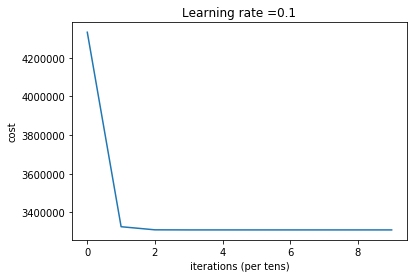

In [440]:
solution = model(X_train,  y_train)

In [441]:
def predict(sol,X_test):
    X_test = normalize_data(X_test)
    X_test = X_test.T
    AL, caches = compute_forward(X_test,sol)
    
    return np.round(AL.T)
        
    
     
    

In [442]:
y_hat = predict(solution,X_test)

In [459]:
def checkright(y_hat, y_test):
    y = np.reshape(y_test, (-1,1))
    ls = np.ndarray.tolist(y == y_hat)
    k = 0
    print(y == y_hat)
    for i in ls:
        if k< 3:
            print(i)
        if i:
            k = k + 1
    
    print(k)
